In [2]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import re
from textblob import TextBlob
import itertools

In [3]:
articles = []

def dawn_article(url):
    try:
        source = requests.get(url, time.sleep(5))
        soup = BeautifulSoup(source.text, 'lxml')

        article_div = soup.find("div", class_="story__content")

        article_paragraphs = article_div.find_all('p')

        whole_article = ''
        for paragraph in article_paragraphs:
            whole_article += paragraph.text

        articles.append(whole_article)

        print('Scraped article', url)
    except:
        print('invalid url', url)

In [4]:
def articles_to_sentences():
    sentence_list = []

    for article in articles:
        sentence_list.extend(split_sentences(article))

    df_sentences = pd.DataFrame(sentence_list, columns=['sentences'])
    print(df_sentences)

    df_sentences.to_json('newsArticles.json')
    print("News articles saved in newsArticles.json File")

In [5]:
def split_sentences(article):
    sentences = re.split(r'[.?!]\s*', article)
    if sentences[-1]:
        return sentences
    else:
        return sentences[:-1]

In [6]:
news_links = []

def dawn_news():
    url = 'https://www.dawn.com/'
    source = requests.get(url)

    with open('test.html', 'w') as f:
        f.write(source.text)

    soup = BeautifulSoup(source.text, 'lxml')

    news_categories = soup.find("div", class_ = "justify-start")

    a_tags = news_categories.findAll('a')

    a_tags.remove(a_tags[0])
    a_tags.remove(a_tags[-1])

    for link in a_tags:
        get_urls_all_news(link['href'])

    for link in set(news_links):
        dawn_article(link)

    articles_to_sentences()

def get_urls_all_news(url):
    source = requests.get('https://www.dawn.com/' + url)
    soup = BeautifulSoup(source.text, 'lxml')


    news_articles_links = soup.findAll("a", class_ = "story__link")

    for news_link in news_articles_links:
        news_links.append(news_link['href'])

    print('News scraped', 'https://www.dawn.com' +  url)

In [7]:
!pip install requests
!pip install beautifulsoup4

In [8]:
dawn_news()

News scraped https://www.dawn.com/latest-news
News scraped https://www.dawn.comhttps://www.dawn.com/trends/gaza-invasion
News scraped https://www.dawn.com/pakistan
News scraped https://www.dawn.com/opinion
News scraped https://www.dawn.com/business
News scraped https://www.dawn.com/world
News scraped https://www.dawn.com/entertainment
News scraped https://www.dawn.com/prism
News scraped https://www.dawn.com/sport
News scraped https://www.dawn.com/magazines
News scraped https://www.dawn.com/tech
News scraped https://www.dawn.com/videos
News scraped https://www.dawn.com/popular
News scraped https://www.dawn.com/newspaper
Scraped article https://www.dawn.com/news/1824843/babar-azam-returns-as-skipper-as-pcb-hands-him-t20-odi-captaincy
Scraped article https://www.dawn.com/news/1823887/china-denounces-malicious-slander-as-us-uk-nz-accuse-beijing-of-cyber-attacks-on-democratic-institutions
Scraped article https://www.dawn.com/news/1796195/between-malnutrition-and-the-right-to-business-where-

In [9]:
sentences_df = pd.read_json('newsArticles.json')
sentences_df.head()

,sentences
0,Batsman Babar Azam made a return to the captai...
1,"In a post on social media platform X, the PCB ..."
10,“As both Shaheen and Babar are not on one-page...
100,"After six months of exclusive breastfeeding, m..."
1000,My comments are as under:The process adopted b...


In [10]:
# Get the number of articles scraped
num_articles_scraped = len(articles)

# Print the number of articles scraped
print(f"Number of articles scraped: {num_articles_scraped}")

Number of articles scraped: 432


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word Cloud for uncleaned data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


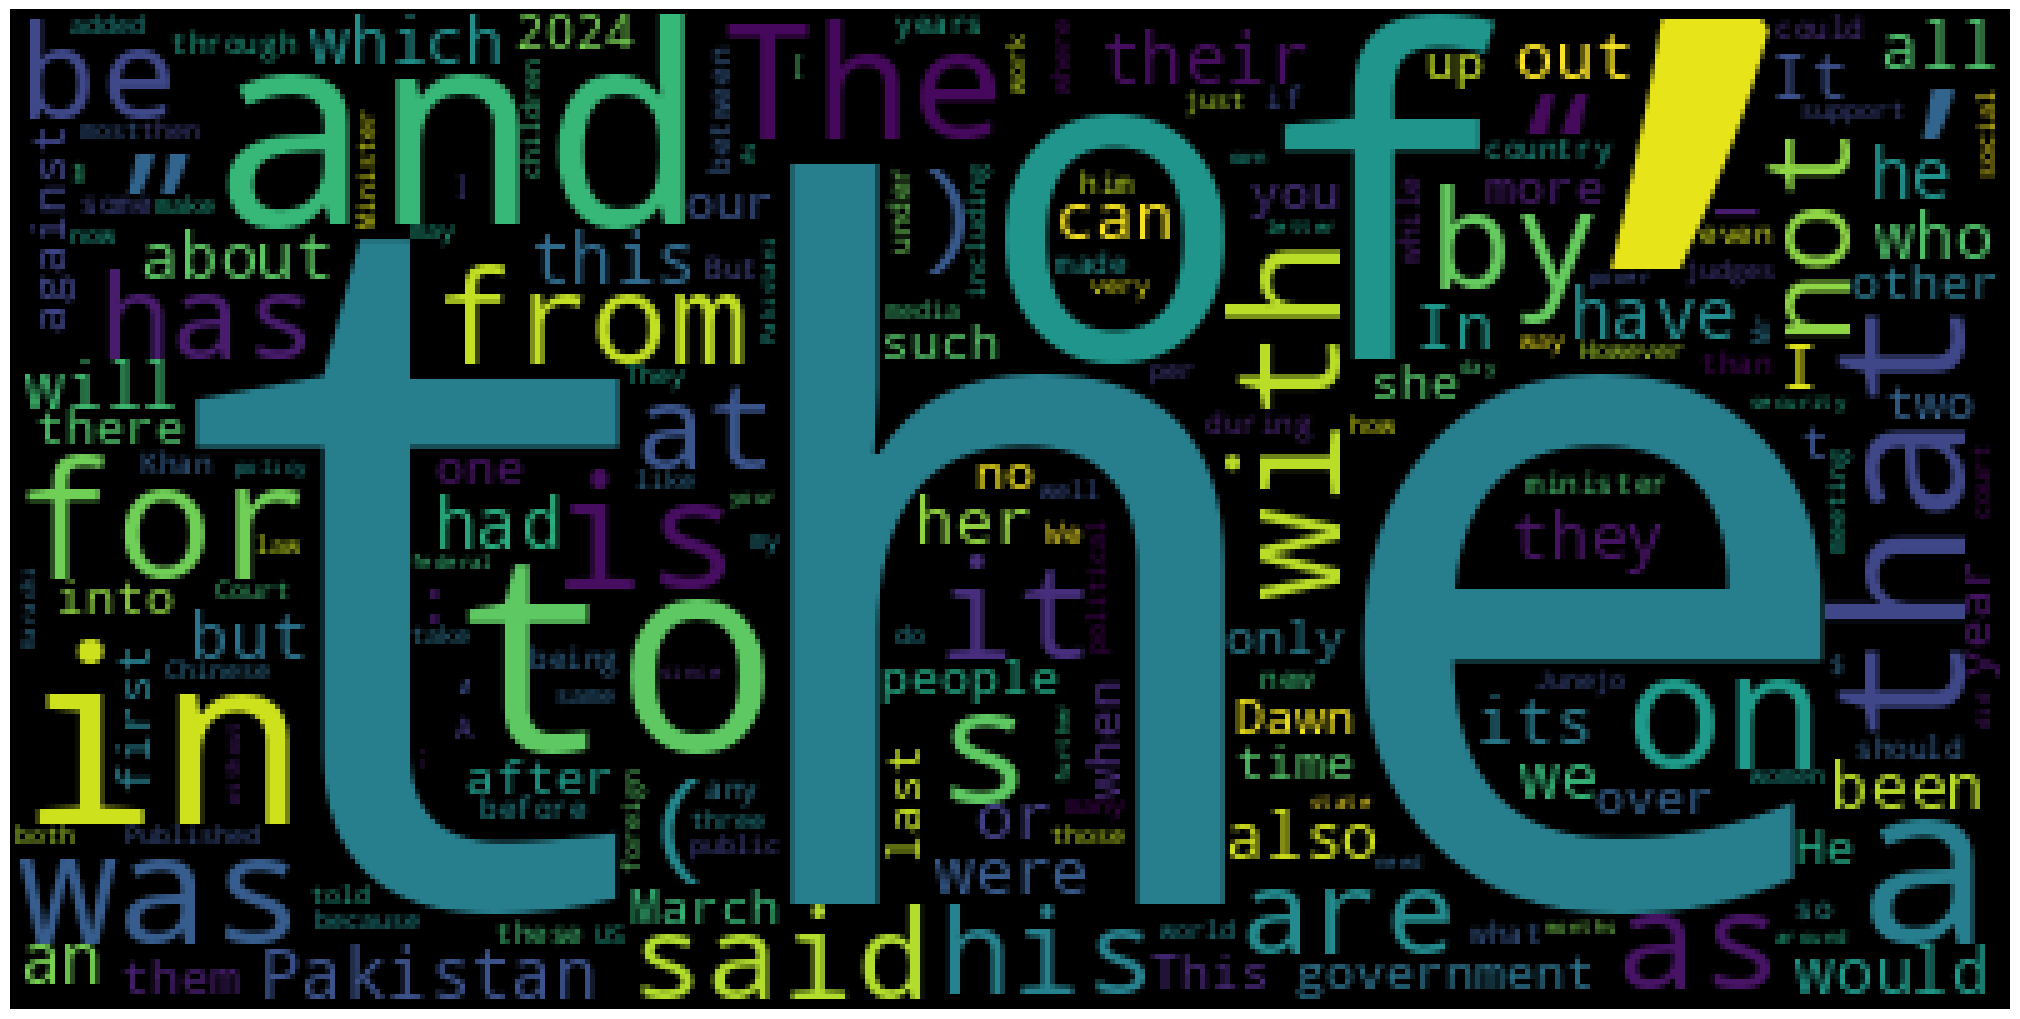

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

sentences = ' '.join(sentences_df["sentences"])
tokens = word_tokenize(sentences)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Pre-Processing

In [14]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

def clean_text(text,replace=''):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text = re.sub(r'\d+', '', str(text))
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = "".join(i for i in text if ord(i) < 128) # remove non-ascii characters
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation characters
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', replace, text) # removes URL from string
    # remove stop words andapplying Lemmatization
    text = ' '.join(lemmatizer.lemmatize(word, pos ="a") for word in text.split() if word not in stop_words)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    return text



In [15]:
sentences_df['sentences'] = sentences_df['sentences'].apply(clean_text)
sentences_df['sentences'].replace('nan', np.nan, inplace=True)
sentences_df['sentences'].replace('', np.nan, inplace=True)
sentences_df = sentences_df.dropna()
sentences_df = sentences_df.drop_duplicates()
sentences_df.reset_index(inplace = True, drop = True)

<ipython-input-14-c83ca0cb1af6>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


Word Cloud for cleaned data

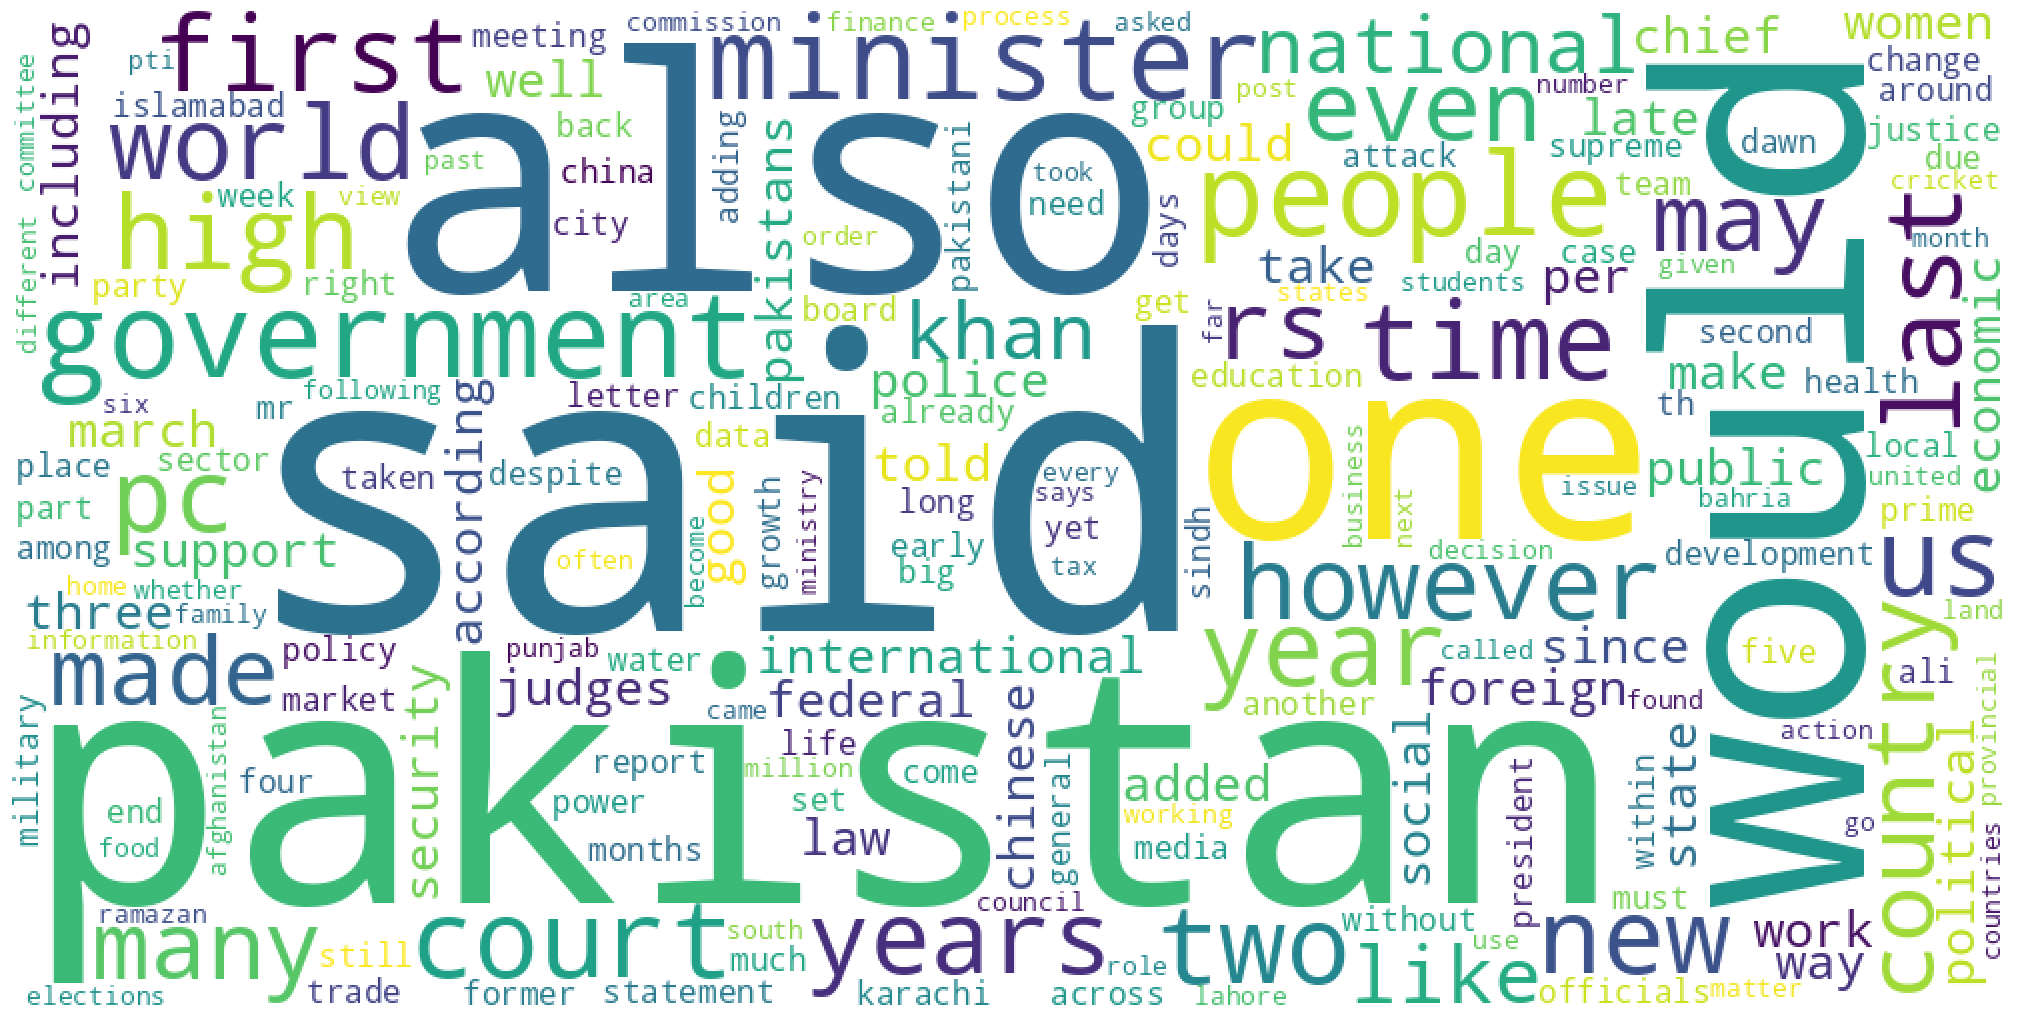

In [16]:
sentences = ' '.join(sentences_df["sentences"])
tokens = word_tokenize(sentences)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(frequency_dist)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Sentiment Analysis

In [17]:
polarity_score = []

for text in sentences_df['sentences']:
    blob = TextBlob(text)
    for sentence in blob.sentences:
        if sentence.sentiment.polarity > 0.0:
            polarity_score.append('positive')
        elif sentence.sentiment.polarity < 0.0:
            polarity_score.append('negative')
        else:
            polarity_score.append('neutral')

sentences_df['sentiment'] = pd.DataFrame(polarity_score)
sentences_df.head()

,sentences,sentiment
0,batsman babar azam made return captaincy mens ...,negative
1,post social media platform x pcb said babar az...,positive
2,shaheen babar onepage last months decision app...,positive
3,six months exclusive breastfeeding medical exp...,positive
4,comments underthe process adopted dr khan anti...,negative


EDA

In [18]:
sentences_df.shape

(11676, 2)

In [19]:
sentences_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  11676 non-null  object
 1   sentiment  11676 non-null  object
dtypes: object(2)
memory usage: 182.6+ KB


In [20]:
sentences_df.describe()

,sentences,sentiment
count,11676,11676
unique,11676,3
top,batsman babar azam made return captaincy mens ...,neutral
freq,1,4881


In [21]:
sentences_df['sentiment'].value_counts()

neutral     4881
positive    4603
negative    2192
Name: sentiment, dtype: int64

<Axes: >

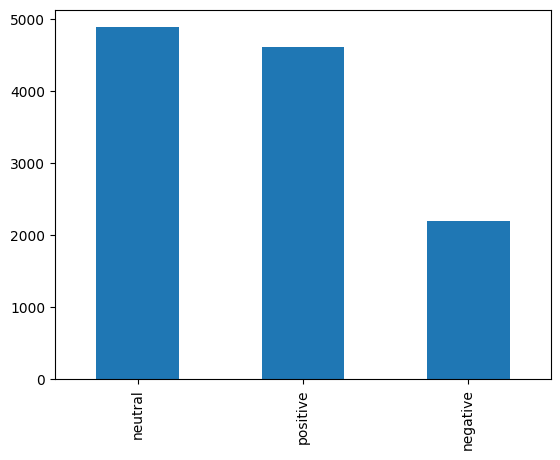

In [22]:
sentences_df['sentiment'].value_counts().plot.bar()


Classification using Machine Learning models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
label = LabelEncoder()
sentences_df_copied = sentences_df.copy()
sentences_df_copied['sentiment'] = label.fit_transform(sentences_df_copied['sentiment'])
sentences_df_copied.head()

,sentences,sentiment
0,batsman babar azam made return captaincy mens ...,0
1,post social media platform x pcb said babar az...,2
2,shaheen babar onepage last months decision app...,2
3,six months exclusive breastfeeding medical exp...,2
4,comments underthe process adopted dr khan anti...,0


In [26]:
classes = ['Negative(0)','Neutral(1)','Positive(2)']
my_categories = ['0', '1', '2']

Splitting for Training and Testing

In [27]:
# Seperate data into feature and results
X, y = sentences_df_copied['sentences'], sentences_df_copied['sentiment']

# Split data in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Uni-Gram and TF-IDF features

In [28]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1))
# TF-IDF BASED FEATURE REPRESENTATION
tfidf.fit(X_train)

train_feature_set = tfidf.transform(X_train)
test_feature_set = tfidf.transform(X_test)

Logistic Regression

accuracy 0.7742377526550188
              precision    recall  f1-score   support

           0       0.88      0.38      0.53       523
           1       0.73      0.92      0.82      1257
           2       0.81      0.80      0.80      1139

    accuracy                           0.77      2919
   macro avg       0.81      0.70      0.72      2919
weighted avg       0.79      0.77      0.76      2919

Confusion matrix, without normalization


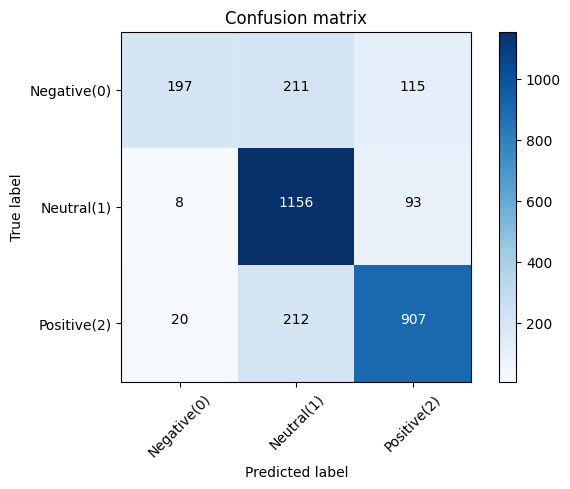

In [29]:
# instantiate the model
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(train_feature_set,y_train)

# make predictions
y_pred = logreg.predict(test_feature_set)
lrm_1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % lrm_1)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

Decision Tree

accuracy 0.855429941760877
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       523
           1       0.90      0.93      0.91      1257
           2       0.86      0.86      0.86      1139

    accuracy                           0.86      2919
   macro avg       0.83      0.82      0.82      2919
weighted avg       0.85      0.86      0.85      2919

Confusion matrix, without normalization


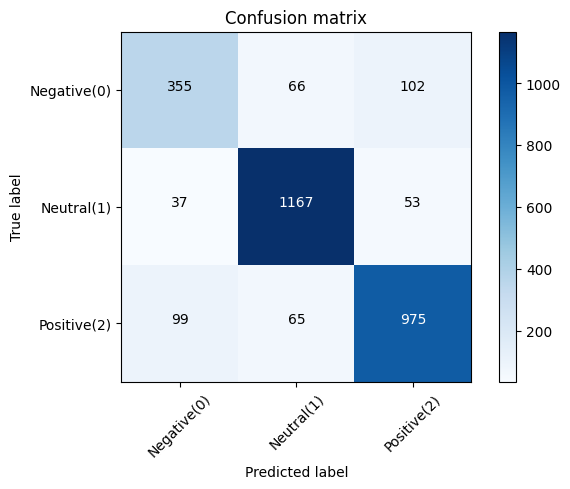

In [30]:
# instantiate the model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = dt_clf.predict(test_feature_set)
dt_1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % dt_1)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

Random Forest

accuracy 0.8615964371360055
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       523
           1       0.84      0.98      0.90      1257
           2       0.90      0.85      0.87      1139

    accuracy                           0.86      2919
   macro avg       0.86      0.81      0.83      2919
weighted avg       0.86      0.86      0.86      2919

Confusion matrix, without normalization


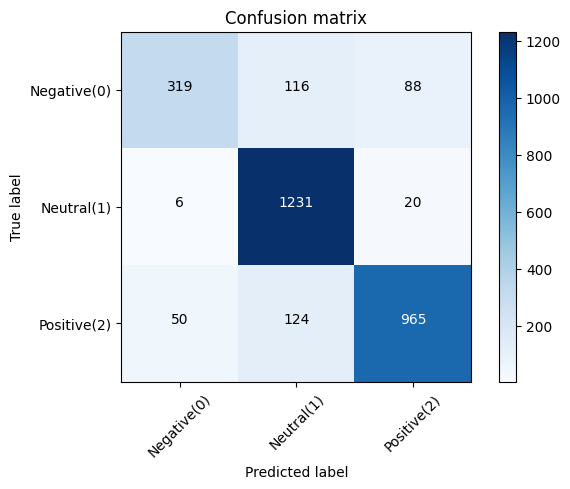

In [31]:
# instantiate the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = rf_clf.predict(test_feature_set)
rf_1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % rf_1)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

Naive Bayes

accuracy 0.658102089756766
              precision    recall  f1-score   support

           0       0.88      0.09      0.17       523
           1       0.73      0.71      0.72      1257
           2       0.60      0.86      0.70      1139

    accuracy                           0.66      2919
   macro avg       0.73      0.55      0.53      2919
weighted avg       0.70      0.66      0.62      2919

Confusion matrix, without normalization


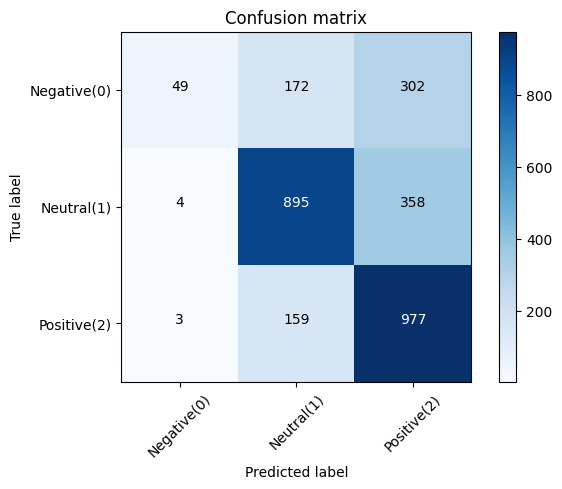

In [32]:
# instantiate the model
nb_clf = MultinomialNB()
nb_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = nb_clf.predict(test_feature_set)
nb_1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % nb_1)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

RNN

Accuracy: 0.7543679342240494
              precision    recall  f1-score   support

           0       0.67      0.52      0.58       523
           1       0.78      0.81      0.80      1257
           2       0.75      0.80      0.78      1139

    accuracy                           0.75      2919
   macro avg       0.73      0.71      0.72      2919
weighted avg       0.75      0.75      0.75      2919

Confusion matrix, without normalization


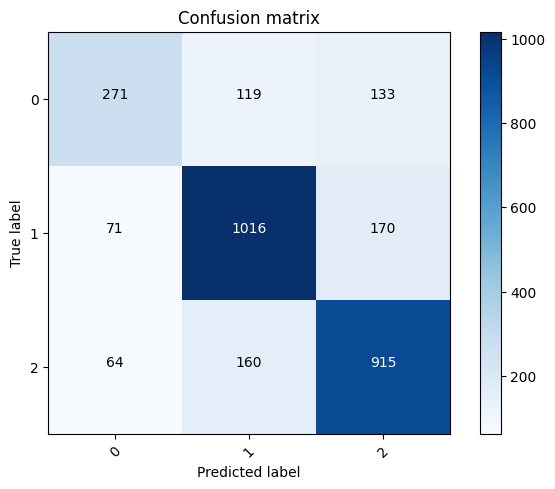

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define your RNN architecture
mlp_clf1 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', max_iter=100)

# Reshape your data if needed
# Assuming train_feature_set and test_feature_set are sequences of fixed length
sequence_length = train_feature_set.shape[1]  # Adjust according to your data
train_feature_set_flattened = train_feature_set.reshape(train_feature_set.shape[0], -1)
test_feature_set_flattened = test_feature_set.reshape(test_feature_set.shape[0], -1)

# Fit the model
mlp_clf1.fit(train_feature_set_flattened, y_train)

# Make predictions
y_pred = mlp_clf1.predict(test_feature_set_flattened)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred, target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=my_categories, normalize=False, title='Confusion matrix')
plt.show()


Uni+Bi-grams and TF-IDF Features

In [34]:


tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
# TF-IDF BASED FEATURE REPRESENTATION
tfidf.fit(X_train)

train_feature_set = tfidf.transform(X_train)
test_feature_set = tfidf.transform(X_test)



Logistic Regression

accuracy 0.7680712572798903
              precision    recall  f1-score   support

           0       0.89      0.36      0.51       523
           1       0.73      0.91      0.81      1257
           2       0.79      0.80      0.80      1139

    accuracy                           0.77      2919
   macro avg       0.81      0.69      0.71      2919
weighted avg       0.78      0.77      0.75      2919

Confusion matrix, without normalization


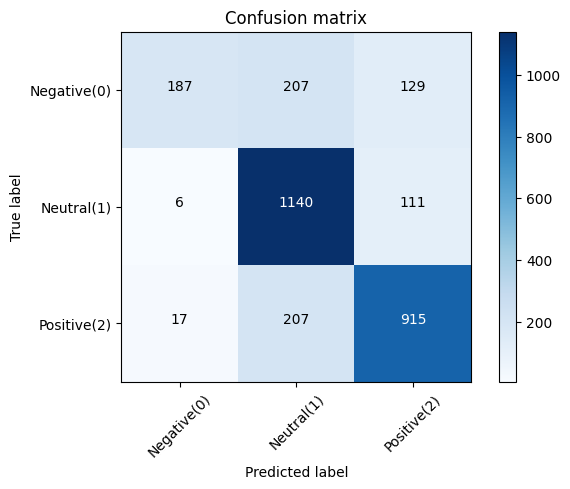

In [35]:
# instantiate the model
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(train_feature_set,y_train)

# make predictions
y_pred = logreg.predict(test_feature_set)
lrm_2 = accuracy_score(y_pred, y_test)

print('accuracy %s' % lrm_2)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

Decision Tree

accuracy 0.8643371017471737
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       523
           1       0.90      0.94      0.92      1257
           2       0.88      0.85      0.86      1139

    accuracy                           0.86      2919
   macro avg       0.84      0.83      0.84      2919
weighted avg       0.86      0.86      0.86      2919

Confusion matrix, without normalization


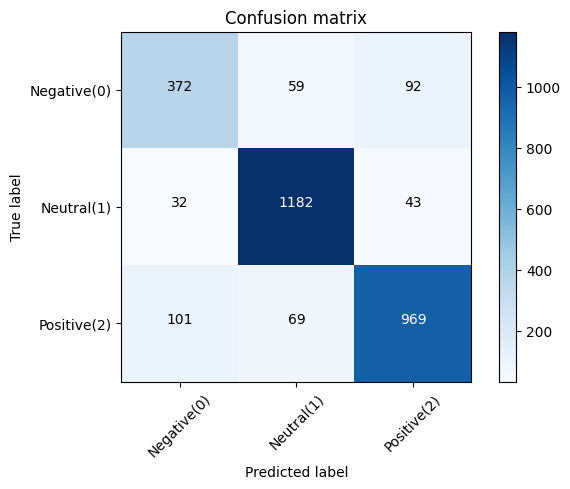

In [36]:
# instantiate the model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = dt_clf.predict(test_feature_set)
dt_2 = accuracy_score(y_pred, y_test)

print('accuracy %s' % dt_2)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

Random Forest

accuracy 0.8499486125385406
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       523
           1       0.82      0.98      0.89      1257
           2       0.90      0.83      0.86      1139

    accuracy                           0.85      2919
   macro avg       0.85      0.80      0.81      2919
weighted avg       0.85      0.85      0.84      2919

Confusion matrix, without normalization


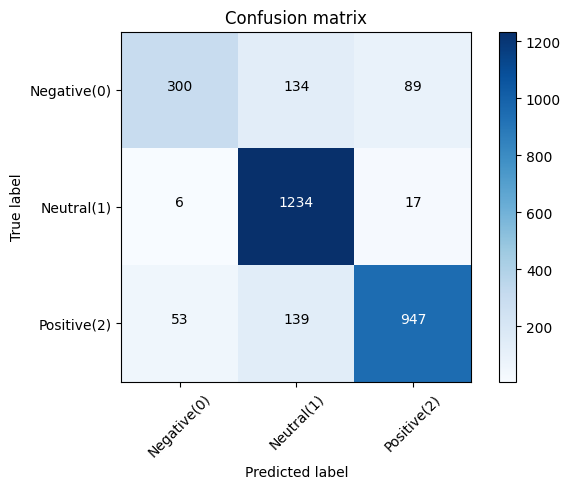

In [37]:


# instantiate the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = rf_clf.predict(test_feature_set)
rf_2 = accuracy_score(y_pred, y_test)

print('accuracy %s' % rf_2)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')



Naive Bayes

accuracy 0.6505652620760535
              precision    recall  f1-score   support

           0       0.92      0.07      0.13       523
           1       0.73      0.70      0.71      1257
           2       0.59      0.86      0.70      1139

    accuracy                           0.65      2919
   macro avg       0.75      0.54      0.51      2919
weighted avg       0.71      0.65      0.60      2919

Confusion matrix, without normalization


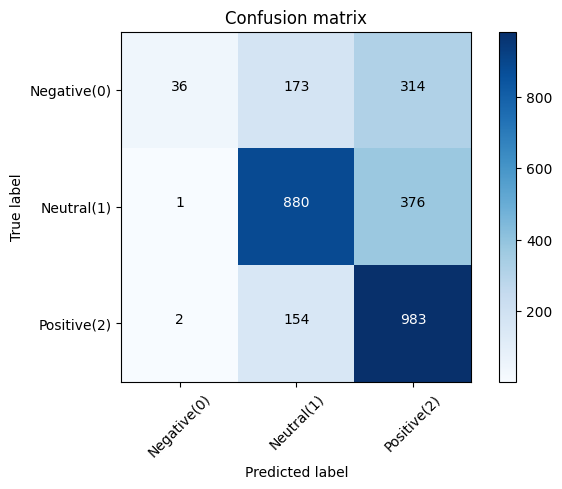

In [38]:
# instantiate the model
nb_clf = MultinomialNB()
nb_clf.fit(train_feature_set,y_train)

# make predictions
y_pred = nb_clf.predict(test_feature_set)
nb_2 = accuracy_score(y_pred, y_test)

print('accuracy %s' % nb_2)
print(classification_report(y_test, y_pred,target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes
                      ,normalize= False,  title='Confusion matrix')

RNN

Accuracy: 0.7324426173347036
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       523
           1       0.76      0.80      0.78      1257
           2       0.73      0.77      0.75      1139

    accuracy                           0.73      2919
   macro avg       0.71      0.69      0.70      2919
weighted avg       0.73      0.73      0.73      2919

Confusion matrix, without normalization


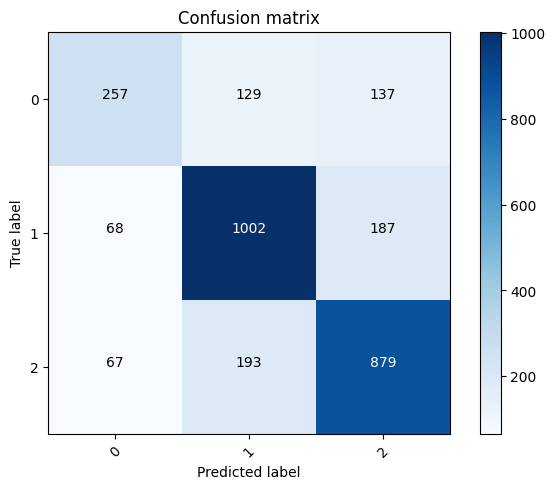

In [39]:
mlp_clf2 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', max_iter=100, random_state=42)

# Reshape your data if needed
# Assuming train_feature_set and test_feature_set are sequences of fixed length
sequence_length = train_feature_set.shape[1]  # Adjust according to your data
train_feature_set_flattened = train_feature_set.reshape(train_feature_set.shape[0], -1)
test_feature_set_flattened = test_feature_set.reshape(test_feature_set.shape[0], -1)

# Fit the model
mlp_clf2.fit(train_feature_set_flattened, y_train)

# Make predictions
y_pred = mlp_clf2.predict(test_feature_set_flattened)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred, target_names=my_categories))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=my_categories, normalize=False, title='Confusion matrix')
plt.show()


Comparison of Machine Learning Models Accuracies

In [40]:
Algorithms = [
              'Logistic Regression uni-gram','Decision Tree uni-gram', 'Random Forest uni-gram',
               'Naive Bayes uni-gram', 'Recurrent Neural Network uni-gram', 'Logistic Regression uni+bi-gram',
              'Decision Tree uni+bi-gram', 'Random Forest uni+bi-gram',
              'Naive Bayes uni+bi-gram', 'Recurrent Neural Network uni+bi-gram'
              ]
accuracy = [
            lrm_1, dt_1, rf_1,
            nb_1, mlp_clf1, lrm_2,
            dt_2, rf_2, nb_2, mlp_clf2,
            ]

In [41]:
print(list(Algorithms))
accuracy_df = pd.DataFrame({"Classifiers": Algorithms,
                      "Accuracy": accuracy}, index = Algorithms)
accuracy_df

['Logistic Regression uni-gram', 'Decision Tree uni-gram', 'Random Forest uni-gram', 'Naive Bayes uni-gram', 'Recurrent Neural Network uni-gram', 'Logistic Regression uni+bi-gram', 'Decision Tree uni+bi-gram', 'Random Forest uni+bi-gram', 'Naive Bayes uni+bi-gram', 'Recurrent Neural Network uni+bi-gram']


,Classifiers,Accuracy
Logistic Regression uni-gram,Logistic Regression uni-gram,0.100
Decision Tree uni-gram,Decision Tree uni-gram,0.200
Random Forest uni-gram,Random Forest uni-gram,0.300
Naive Bayes uni-gram,Naive Bayes uni-gram,0.400
Recurrent Neural Network uni-gram,Recurrent Neural Network uni-gram,0.500
Logistic Regression uni+bi-gram,Logistic Regression uni+bi-gram,0.050
Decision Tree uni+bi-gram,Decision Tree uni+bi-gram,0.180
Random Forest uni+bi-gram,Random Forest uni+bi-gram,0.040
Naive Bayes uni+bi-gram,Naive Bayes uni+bi-gram,0.015
Recurrent Neural Network uni+bi-gram,Recurrent Neural Network uni+bi-gram,0.250


graphical comparison

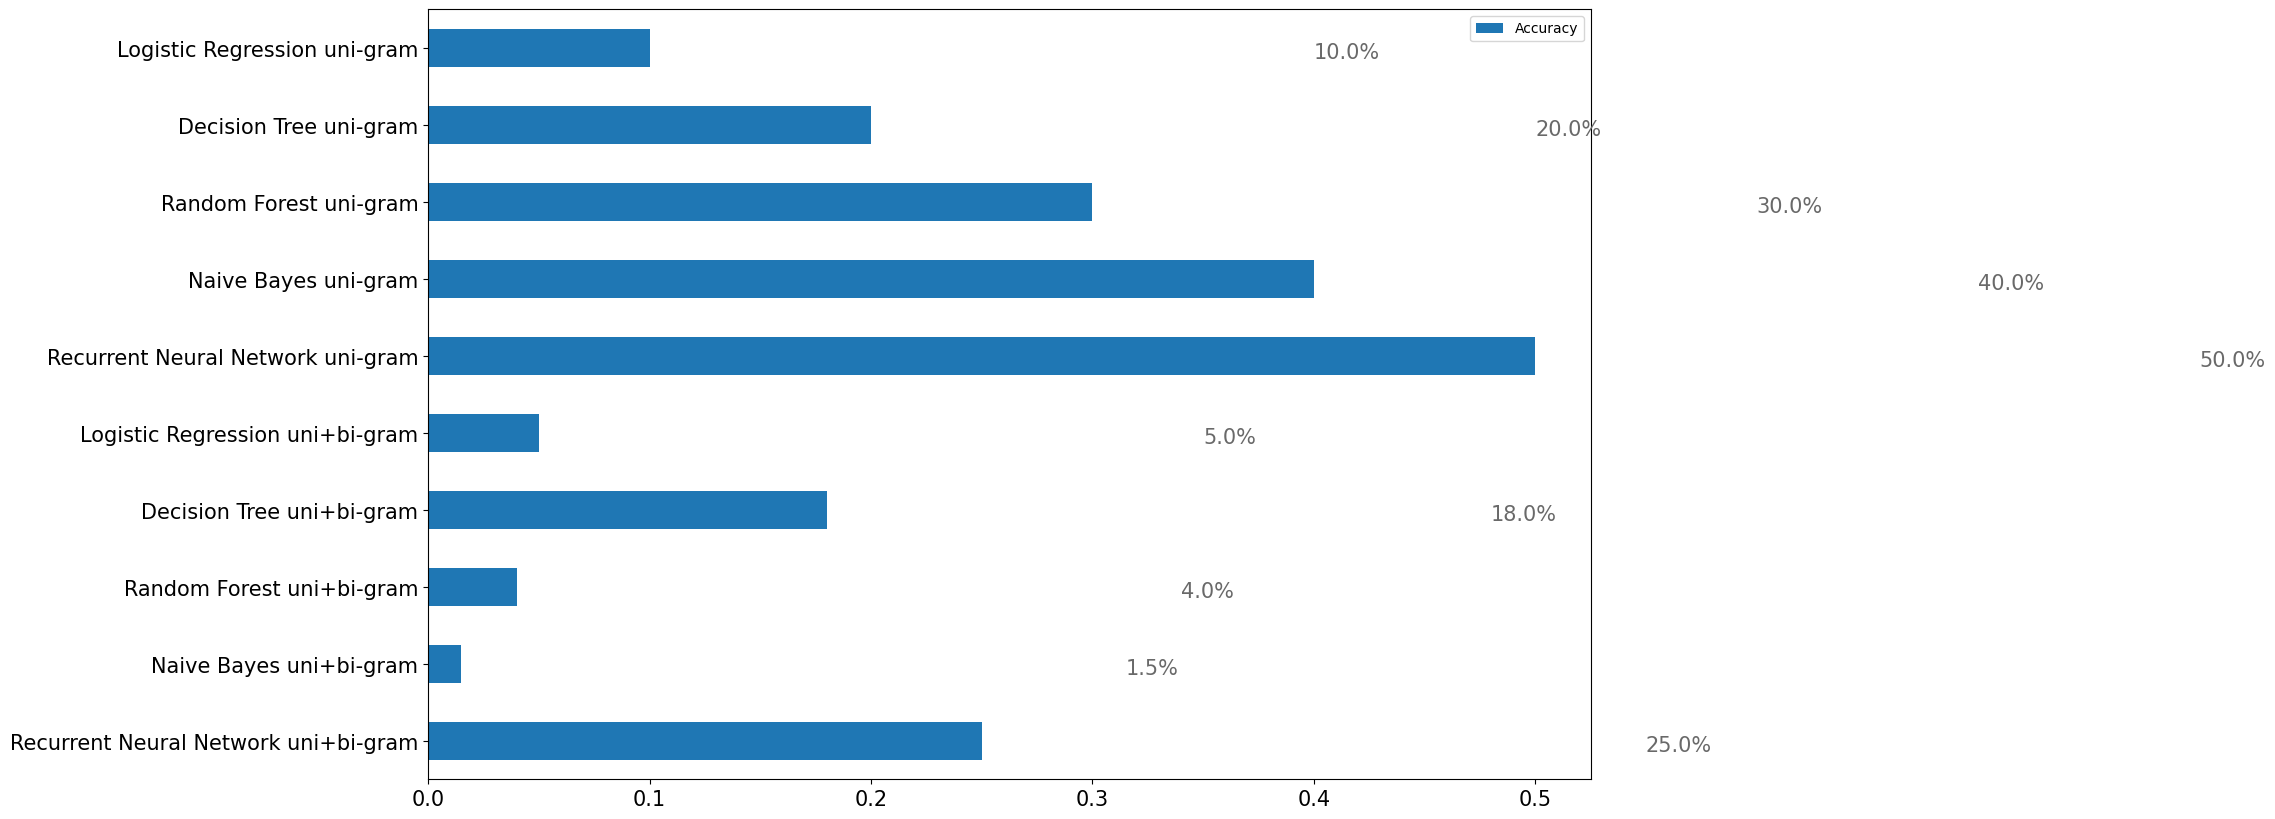

In [42]:
ax = accuracy_df.plot.barh(figsize=(15,10),fontsize=15)
totals = []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width())*100,4))+'%', fontsize=15,
color='dimgrey')

# invert for largest on top
ax.invert_yaxis()